 Zillow 2016 Regression Analysis

## Project Planning

### Goals

(see background)...your customer is the zillow data science team.  state your goals as if you were delivering this to zillow.  They have asked for something from you (see 'background') and you are basically communicating in a more concise way, and very clearly, the goals as you understand them and as you have taken and acted upon through your research. 

*Project Overview
Background:
Zillow wants to improve their Zestimate. The zestimate is estimated value of a home. Zillow theorizes that there is more information to be gained to improve its existing model. Because of that, Zillow wants you to develop a model to predict the error between the Zestimate and the sales price of a home. In predicting the error, you will discover features that will help them improve the Zestimate estimate itself. Your goal of this project is to develop a linear regression model that will best predict the log error of the Zestimate. The error is the difference of the sales price and the Zestimate. The log error is computed by taking the log function of that error. You don't need to worry about the fact that the error is of a logarithmic function. It is a continuous number that represents an error rate.*



### Deliverables

What should the zillow team expect to receive from you?  Again, as you were communicating to them, not to your instructors.  

*your deliverables:*
1. *A report (in the form of a presentation, both verbal and through a slides) that summarizes your findings about the drivers of the Zestimate error. This will come from the analysis you do during the exploration phase of the pipeline. In the report, you will have charts that visually tell the story of what is driving the errors.*

2. *A Jupyter notebook, titled 'Regression_Proj_YourName', that contains a clearly labeled section and code clearly documented for each the stages below (project planning, data acquisition, data prep, exploration, and modeling). All of the work will take place in your jupyter notebook.*

### Data Dictionary & Details

**we will be using 2016 data so do NOT use properties_2017 or predictions_2017**  

- logerror
- bathroomcnt
- bedroomcnt
- calculatedfinishedsquarefeet
- fullbathcnt
- garagecarcnt
- roomcnt
- yearbuilt
- taxvaluedollarcnt
- taxamount

### Initial Thoughts, Ideas, Hypotheses

Goal is to predict the log error ((measured between sales price and predicted sales price.  We have various features, but not the actual sales price.    
Some initial thoughts on features that may have increased/decreased log error
    1) Error could have been increased on large lots.
    2) Older homes could me more difficult to predict, so check year built.
    3) Is the time of year a factor (school in/out),  can check transaction date
    4) Square footage, bad/bath count could provide some insights on increasing or decreasing error.

### Environment


In [34]:
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, f_classif
from env import user, host, pw, datadirpath

### Data Acquisition - via csv


Make a re-useable list of columns to analyze, call it FeatureList and feed to to pd.read.csv to create the dataframe only containing the needed colums.   Note:  If you decide on different features - change the "FeatureList" and rerun

In [35]:
FeatureList = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','fullbathcnt','garagecarcnt','roomcnt','yearbuilt','taxvaluedollarcnt','taxamount','regionidzip','lotsizesquarefeet','unitcnt']
columnstopull = ['parcelid'] + FeatureList
csvfilename = "properties_2016.csv"
properties = pd.read_csv(datadirpath+csvfilename, usecols=columnstopull)
properties.head()


,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,lotsizesquarefeet,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt,taxamount
0,10754147,0.0,0.0,NaN,NaN,NaN,85768.0,96337.0,0.0,NaN,NaN,9.0,NaN
1,10759547,0.0,0.0,NaN,NaN,NaN,4083.0,96337.0,0.0,NaN,NaN,27516.0,NaN
2,10843547,0.0,0.0,73026.0,NaN,NaN,63085.0,96095.0,0.0,2.0,NaN,1413387.0,20800.37
3,10859147,0.0,0.0,5068.0,NaN,NaN,7521.0,96424.0,0.0,NaN,1948.0,1156834.0,14557.57
4,10879947,0.0,0.0,1776.0,NaN,NaN,8512.0,96450.0,0.0,1.0,1947.0,433491.0,5725.17


In [36]:
csvfilename = "train_2016_v2.csv"
logerrors = pd.read_csv(datadirpath+csvfilename)
logerrors.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


    Using pd.merge on the dataframes and checking for duplicates validate="one_to_one",   there are duplicates
use pd.concat to find out how many duplicated parcelids.    There are 249 duplicated parcelid s
    Inspection of the duplicates indicates that these are corrected rows, with a later transaction date always occuring on the last duplicate.   

In [37]:
pd.concat(dupes for _, dupes in logerrors.groupby("parcelid") if len(dupes) > 1)

,parcelid,logerror,transactiondate
10828,10736972,-0.0460,2016-02-22
10829,10736972,-0.0367,2016-12-14
9177,10790468,-0.0450,2016-02-12
9178,10790468,-0.0440,2016-09-13
2226,10796614,-0.1267,2016-01-13
2227,10796614,-0.0704,2016-06-14
24522,10798910,-0.0471,2016-04-12
24523,10798910,-0.0274,2016-05-24
6291,10799924,0.0478,2016-01-29
6292,10799924,0.4121,2016-08-09


Now remove the duplicates (keeping the last occurance) based on parcel id

In [38]:
logerrors.drop_duplicates(subset='parcelid', keep='last', inplace=True)

  and merge the two dataframes, checking for duplicates 

In [39]:
frames = [properties, logerrors]
df = pd.merge(properties, logerrors, on='parcelid', how='inner', validate="one_to_one")
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,lotsizesquarefeet,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,3.0,1264.0,2.0,2.0,1735.0,97081.0,5.0,NaN,1986.0,191811.0,2015.06,0.0953,2016-01-27
1,17088994,1.0,2.0,777.0,1.0,1.0,NaN,97083.0,4.0,NaN,1990.0,239679.0,2581.30,0.0198,2016-03-30
2,17100444,2.0,3.0,1101.0,2.0,2.0,6569.0,97113.0,5.0,NaN,1956.0,47853.0,591.64,0.0060,2016-05-27
3,17102429,1.5,2.0,1554.0,1.0,2.0,7400.0,97113.0,5.0,NaN,1965.0,62914.0,682.78,-0.0566,2016-06-07
4,17109604,2.5,4.0,2415.0,2.0,2.0,6326.0,97084.0,8.0,NaN,1984.0,554000.0,5886.92,0.0573,2016-08-08


### Data Preparation

Goal: leave this section with a dataset that is ready to be analyzed. 

#### Create a variable, `colnames`, that is a list of the column names. 
Why? You will likely reference this variable later.

In [40]:
colnames = FeatureList
colnames

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'garagecarcnt',
 'roomcnt',
 'yearbuilt',
 'taxvaluedollarcnt',
 'taxamount',
 'regionidzip',
 'lotsizesquarefeet',
 'unitcnt']

#### Identify the data types of each variable. Why? 
You need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable. If it does not, make necessary changes.

In [41]:
df.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,lotsizesquarefeet,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt,taxamount,logerror
count,9.015000e+04,90150.000000,90150.000000,89492.000000,88974.000000,29897.000000,8.001400e+04,90115.000000,90150.000000,58271.000000,89397.000000,9.014900e+04,90144.000000,90150.000000
mean,1.298488e+07,2.279545,3.031936,1773.096869,2.241172,1.812055,2.912064e+04,96586.196216,1.478580,1.110244,1968.539761,4.576379e+05,5983.070888,0.011526
std,2.505517e+06,1.004133,1.156114,928.136339,0.963106,0.608865,1.217909e+05,3663.847246,2.819802,0.797389,23.763165,5.548532e+05,6838.506814,0.160968
min,1.071174e+07,0.000000,0.000000,2.000000,1.000000,0.000000,1.670000e+02,95982.000000,0.000000,1.000000,1885.000000,2.200000e+01,49.080000,-4.605000
25%,1.155970e+07,2.000000,2.000000,1184.000000,2.000000,2.000000,5.704000e+03,96193.000000,0.000000,1.000000,1953.000000,1.990560e+05,2873.260000,-0.025300
50%,1.254744e+07,2.000000,3.000000,1540.000000,2.000000,2.000000,7.200000e+03,96393.000000,0.000000,1.000000,1970.000000,3.429310e+05,4543.100000,0.006000
75%,1.422757e+07,3.000000,4.000000,2095.000000,3.000000,2.000000,1.168175e+04,96987.000000,0.000000,1.000000,1987.000000,5.405890e+05,6900.165000,0.039200
max,1.629608e+08,20.000000,16.000000,22741.000000,20.000000,24.000000,6.971010e+06,399675.000000,18.000000,143.000000,2015.000000,2.775000e+07,321936.090000,4.737000


#### Identify the columns that have missing values and the number of missing values in each column. 
Why? Missing values are going to cause issues down the line so you will need to handle those appropriately. For each variable with missing values, if it makes sense to replace those missing with a 0, do so. For those where that doesn't make sense, decide if you should drop the entire observations (rows) that contain the missing values, or drop the entire variable (column) that contains the missing values.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90150 entries, 0 to 90149
Data columns (total 15 columns):
parcelid                        90150 non-null int64
bathroomcnt                     90150 non-null float64
bedroomcnt                      90150 non-null float64
calculatedfinishedsquarefeet    89492 non-null float64
fullbathcnt                     88974 non-null float64
garagecarcnt                    29897 non-null float64
lotsizesquarefeet               80014 non-null float64
regionidzip                     90115 non-null float64
roomcnt                         90150 non-null float64
unitcnt                         58271 non-null float64
yearbuilt                       89397 non-null float64
taxvaluedollarcnt               90149 non-null float64
taxamount                       90144 non-null float64
logerror                        90150 non-null float64
transactiondate                 90150 non-null object
dtypes: float64(13), int64(1), object(1)
memory usage: 11.0+ MB


Cleanup,   1) drop column "garagecarcnt' completly because only one-third of the rows have values 
           2) drop rows containing null values 
           3) change parcelid, regionidzip, yearbuilt to strings.               
           5) Drop rows where calculatedfinishedsquarefeet <= 300 square feet (not reasonable)
           6) eliminate roomcnt, values don't look correct (min, IQR nonsensical)  
           7) add column called logerrorabs
           8) add column called bedbathcount, which is aggregation of bedroomcount + bathroomcount
           9) use unitcnt to filter out any rows from multi-family dwellings (unitcnt > 1)
           10) Create a new column called sales_month, which is the month the sales transaction occured
           11) Drop rows with extreme outliers in calculatedfinishedsquarefeet (above xxxx)
           

In [43]:
df.drop(columns=['garagecarcnt'], inplace=True)

In [44]:
df.drop(columns=['roomcnt'], inplace=True)

In [45]:
indexNames = df[ (df['unitcnt'] > 1) ].index
df.drop(indexNames , inplace=True)

In [46]:
df.drop(columns=['unitcnt'], inplace=True)

In [47]:
df.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,lotsizesquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror
count,8.631100e+04,86311.000000,86311.000000,85653.000000,85507.000000,7.620400e+04,86276.000000,85623.000000,8.631000e+04,86306.000000,86311.000000
mean,1.301714e+07,2.255373,2.979377,1744.395234,2.205305,3.017896e+04,96598.274317,1969.706598,4.590019e+05,5981.705948,0.011713
std,2.546732e+06,0.960954,1.040659,910.336144,0.923847,1.246255e+05,3598.056024,23.126727,5.586244e+05,6876.776810,0.156782
min,1.071174e+07,0.000000,0.000000,2.000000,1.000000,1.670000e+02,95982.000000,1885.000000,2.200000e+01,49.080000,-4.605000
25%,1.154230e+07,2.000000,2.000000,1170.000000,2.000000,5.750000e+03,96208.000000,1954.000000,1.988512e+05,2859.577500,-0.024300
50%,1.259890e+07,2.000000,3.000000,1516.000000,2.000000,7.241000e+03,96403.000000,1971.000000,3.432420e+05,4530.710000,0.006000
75%,1.426492e+07,3.000000,4.000000,2055.000000,3.000000,1.221125e+04,96987.000000,1987.000000,5.408395e+05,6884.977500,0.038300
max,1.629608e+08,20.000000,16.000000,20013.000000,20.000000,6.971010e+06,399675.000000,2015.000000,2.775000e+07,321936.090000,4.737000


In [48]:
df['parcelid'] = df['parcelid'].apply(lambda x: "{:.0f}".format(x) if x is not None else x)

In [18]:
# df['regionidzip'] = df['regionidzip'].apply(lambda x: "z"+"{:.0f}".format(x) if x is not None else x)
# wanted to make zipcode a string, but too many seaborn problems plotting it

In [19]:
# df['yearbuilt'] = df['yearbuilt'].apply(lambda x: "y"+"{:.0f}".format(x) if x is not None else x)
# wanted to make yearbuilt a string, but too many seaborn problems plotting it

In [49]:
indexNames = df[ (df['calculatedfinishedsquarefeet'] <= 300) ].index
df.drop(indexNames , inplace=True)

In [50]:
df['bedbathcnt'] = df['bedroomcnt'] + df['bathroomcnt']  

In [51]:
df['logerrorabs'] = df['logerror'].abs()

In [52]:
df['sales_month'] = pd.to_numeric(df['transactiondate'].str.slice(5,7))

In [53]:
indexNames = df[ (df['calculatedfinishedsquarefeet'] > 7500) ].index
df.drop(indexNames , inplace=True)

In [54]:
indexNames = df[ (df['lotsizesquarefeet'] > 65_340) ].index
df.drop(indexNames , inplace=True)

In [55]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,lotsizesquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,bedbathcnt,logerrorabs,sales_month
count,79694.000000,79694.000000,79081.000000,78950.000000,69589.000000,79660.000000,79053.000000,7.969300e+04,79689.000000,79694.000000,79694.000000,79694.000000,79694.000000
mean,2.246242,3.029162,1758.005463,2.191121,10048.169835,96615.054356,1968.726955,4.583635e+05,5979.338986,0.011563,5.275403,0.065663,5.852611
std,0.937855,1.020699,849.365214,0.900383,9806.941771,3585.515931,23.494822,4.963680e+05,6159.072337,0.155738,1.762267,0.141691,2.806888
min,0.000000,0.000000,304.000000,1.000000,167.000000,95982.000000,1885.000000,2.200000e+01,49.080000,-4.605000,0.000000,0.000000,1.000000
25%,2.000000,2.000000,1194.000000,2.000000,5555.000000,96212.000000,1953.000000,2.008420e+05,2903.000000,-0.024300,4.000000,0.013900,4.000000
50%,2.000000,3.000000,1542.000000,2.000000,6994.000000,96433.000000,1969.000000,3.505560e+05,4613.160000,0.006000,5.000000,0.031500,6.000000
75%,3.000000,4.000000,2090.000000,3.000000,9724.000000,96993.000000,1987.000000,5.528570e+05,7019.980000,0.038300,6.000000,0.066700,8.000000
max,10.000000,16.000000,7499.000000,10.000000,65340.000000,399675.000000,2015.000000,1.449943e+07,248725.740000,4.737000,21.000000,4.737000,12.000000


In [56]:
df.dropna(how='any',axis=0, inplace=True)

In [57]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,lotsizesquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,bedbathcnt,logerrorabs,sales_month
count,69131.000000,69131.000000,69131.000000,69131.000000,69131.000000,69131.000000,69131.00000,6.913100e+04,69131.000000,69131.000000,69131.000000,69131.000000,69131.000000
mean,2.280366,3.155516,1813.249034,2.220784,10048.719542,96581.861234,1965.72487,4.674506e+05,6107.261851,0.012174,5.435883,0.066728,5.868568
std,0.942526,0.967152,870.480513,0.923120,9802.049055,3845.647932,22.93725,5.162492e+05,6365.117116,0.155631,1.706746,0.141126,2.810264
min,1.000000,0.000000,304.000000,1.000000,167.000000,95982.000000,1885.00000,7.704000e+03,49.080000,-4.605000,1.000000,0.000000,1.000000
25%,2.000000,3.000000,1227.000000,2.000000,5565.000000,96193.000000,1951.00000,1.950000e+05,2923.305000,-0.025300,4.000000,0.013900,4.000000
50%,2.000000,3.000000,1589.000000,2.000000,6997.000000,96385.000000,1964.00000,3.523910e+05,4693.130000,0.006000,5.000000,0.032500,6.000000
75%,3.000000,4.000000,2172.000000,3.000000,9726.000000,96987.000000,1984.00000,5.670000e+05,7148.830000,0.039200,6.000000,0.068300,8.000000
max,10.000000,16.000000,7499.000000,10.000000,65340.000000,399675.000000,2015.00000,1.449943e+07,248725.740000,4.737000,21.000000,4.737000,12.000000


In [58]:
indexNames = df[ (df['bedbathcnt'] > 15) ].index
df.drop(indexNames , inplace=True)

In [59]:
indexNames = df[ (df['logerrorabs'] > .25) ].index
df.drop(indexNames , inplace=True)

In [60]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,lotsizesquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,bedbathcnt,logerrorabs,sales_month
count,66167.000000,66167.000000,66167.000000,66167.000000,66167.000000,66167.000000,66167.000000,6.616700e+04,66167.000000,66167.000000,66167.000000,66167.000000,66167.000000
mean,2.285565,3.161425,1814.537186,2.224916,10010.187762,96583.320658,1966.175843,4.661462e+05,6076.833753,0.005948,5.446990,0.046216,5.876147
std,0.931204,0.958679,861.183400,0.912030,9772.710123,3748.947747,22.779691,5.049621e+05,6224.894849,0.066015,1.687248,0.047512,2.805696
min,1.000000,0.000000,304.000000,1.000000,167.000000,95982.000000,1885.000000,7.704000e+03,49.080000,-0.249700,1.000000,0.000000,1.000000
25%,2.000000,3.000000,1232.000000,2.000000,5564.000000,96197.000000,1952.000000,1.988090e+05,2954.845000,-0.024300,4.000000,0.013100,4.000000
50%,2.000000,3.000000,1594.000000,2.000000,6994.000000,96387.000000,1964.000000,3.553340e+05,4716.890000,0.005000,5.000000,0.030500,6.000000
75%,3.000000,4.000000,2172.500000,3.000000,9678.000000,96987.000000,1984.000000,5.678340e+05,7139.885000,0.035400,6.000000,0.061100,8.000000
max,10.000000,9.000000,7499.000000,10.000000,65340.000000,399675.000000,2015.000000,1.449943e+07,248725.740000,0.250000,15.000000,0.250000,12.000000


In [61]:
indexNames = df[ (df['taxvaluedollarcnt'] > 5_000_000) ].index
df.drop(indexNames , inplace=True)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66081 entries, 0 to 90148
Data columns (total 15 columns):
parcelid                        66081 non-null object
bathroomcnt                     66081 non-null float64
bedroomcnt                      66081 non-null float64
calculatedfinishedsquarefeet    66081 non-null float64
fullbathcnt                     66081 non-null float64
lotsizesquarefeet               66081 non-null float64
regionidzip                     66081 non-null float64
yearbuilt                       66081 non-null float64
taxvaluedollarcnt               66081 non-null float64
taxamount                       66081 non-null float64
logerror                        66081 non-null float64
transactiondate                 66081 non-null object
bedbathcnt                      66081 non-null float64
logerrorabs                     66081 non-null float64
sales_month                     66081 non-null int64
dtypes: float64(12), int64(1), object(2)
memory usage: 8.1+ MB


#### Create a list of the independent variable names (aka attributes) and assign it to `x_vars` 
Why? During exploration, you will likely use this list to refer to the attribute names.

In [32]:
x_vars = ['calculatedfinishedsquarefeet','lotsizesquarefeet','regionidzip','yearbuilt','taxvaluedollarcnt','sales_month','bedbathcnt']


SyntaxError: invalid syntax (<ipython-input-32-595d68569c77>, line 1)

#### Clearly identify your dependent (target) variable. 
- What is the name of the variable? 
- Is it discrete or continuous?

The dependent variable is logerror,  it is continuous.

#### View the distribution of the numeric variables
- plot a histogram and box plot of each variable. 
- Why? To see the distribution, skewness, outliers, and unit scales. You will use this information in your decision of whether to normalize, standardize or neither.

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


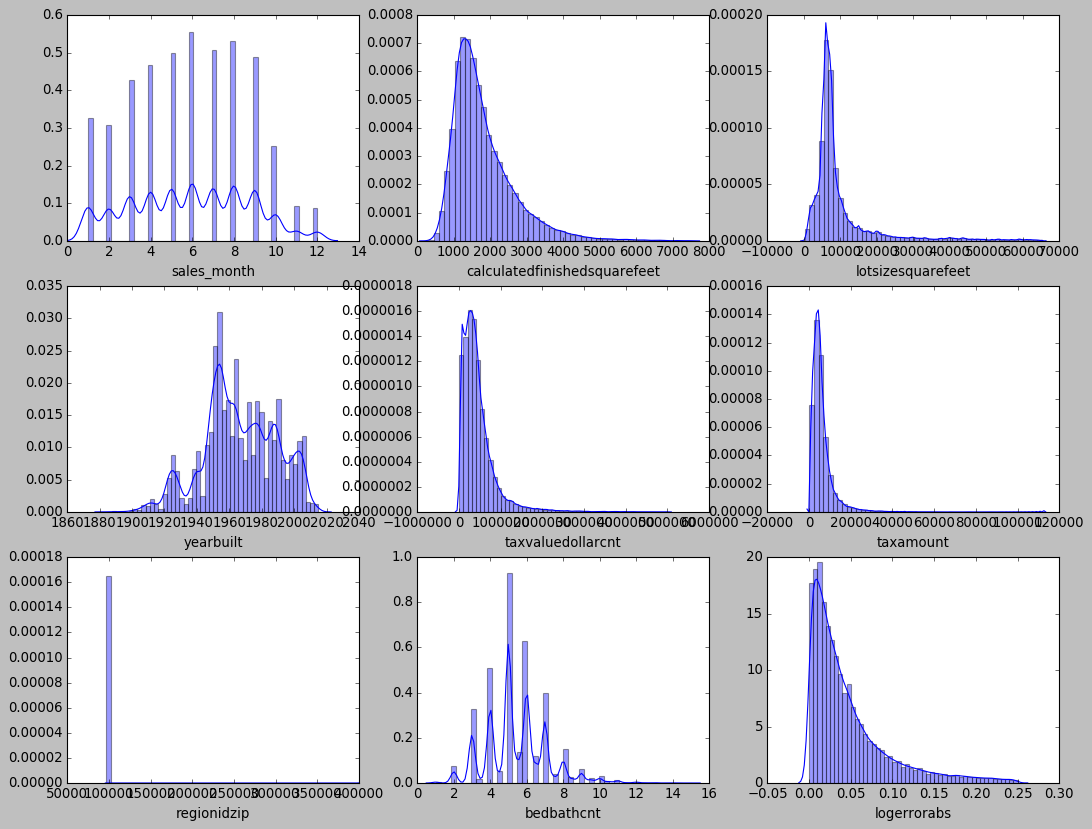

In [63]:
plt.figure(figsize=(16,12))
plt.subplot(3,3,1)
sns.distplot(df.sales_month)
plt.subplot(3,3,2)
sns.distplot(df.calculatedfinishedsquarefeet)
plt.subplot(3,3,3)
sns.distplot(df.lotsizesquarefeet)
plt.subplot(3,3,4)
sns.distplot(df.yearbuilt)
plt.subplot(3,3,5)
sns.distplot(df.taxvaluedollarcnt)
plt.subplot(3,3,6)
sns.distplot(df.taxamount)
plt.subplot(3,3,7)
sns.distplot(df.regionidzip)
plt.subplot(3,3,8)
sns.distplot(df.bedbathcnt)
plt.subplot(3,3,9)
sns.distplot(df.logerrorabs)
plt.show()


#### BONUS:  Data standardization 
Create a new data frame that is the min-max normalization of the independent variable in the original data frame (+ the original dependent variable). You will normalize each of the numeric independent variables independently, i.e. using the min and max of each variable, not the min/max of the whole dataframe. Why? Regression is very sensitive to difference in units. It will be almost impossible to extract a meaningful linear regression model with such extreme differences in scale. For more context, see: https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
You will use this dataframe in the future analysis.

### Data Exploration

Goal is to address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, the answers to your questions and your customer's questions that will reach the goal. 

Comment:  try it on logerrorsquared first

#### Split data into training and test datasets
   first,  drop out the columns we didn't see any relationship on (that we used mostly for filtering)

In [64]:
df.drop(columns=['bathroomcnt'], inplace=True)
df.drop(columns=['bedroomcnt'], inplace=True)
df.drop(columns=['fullbathcnt'], inplace=True)
df.drop(columns=['logerror'], inplace=True)
df.drop(columns=['taxamount'], inplace=True)
df.drop(columns=['transactiondate'], inplace=True)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66081 entries, 0 to 90148
Data columns (total 9 columns):
parcelid                        66081 non-null object
calculatedfinishedsquarefeet    66081 non-null float64
lotsizesquarefeet               66081 non-null float64
regionidzip                     66081 non-null float64
yearbuilt                       66081 non-null float64
taxvaluedollarcnt               66081 non-null float64
bedbathcnt                      66081 non-null float64
logerrorabs                     66081 non-null float64
sales_month                     66081 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 5.0+ MB


In [66]:
X = df.drop(['parcelid'], axis=1)
y = df[['logerrorabs']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Create a jointplot for each independent variable (normalized version) with the dependent variable. 

Be sure you have Pearson's r and p-value annotated on each plot.

In [ ]:
df.info()

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 

You may want to use a normalized dataframe (if you did that) or adjust the axis scale (set to logarithmic, e.g) so you can more clearly view the interactions.

In [ ]:
g = sns.PairGrid(train)

#### Create a heatmap of the correlation between each variable pair.

#### Summarize your conclusions from all of these steps.  

#### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
Run a t-test to test this difference.

#### Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)

### Data Modeling

#### Feature Engineering & Selection

#### Are there new features you could create based on existing features that might be helpful? 

Come up with at least one possible new feature that is a calculation from 2+ existing variables. 

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

#### Train & Test Model

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

- Make any changes as necessary to improve your model.

- Identify the best model after all training

- Compare the models by plotting the predictions of each model with actual values (see plot right above section 12 in 'Regression in Python' lesson

(the predictions are a 1 x 83 two dimensional matrix, but we want just a single array of predictions. We can use the .ravel method to achieve this.)

`pd.DataFrame({'actual': y_train.final_grade,  
              'lm1': y_pred_lm1.ravel(),  
              'lm2': y_pred_lm2.ravel()})\  
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\  
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')  

plt.plot([60, 100], [60, 100], c='black', ls=':')  
plt.ylim(60, 100)  
plt.xlim(60, 100)  
plt.title('Predicted vs Actual Final Grade')`  

#### Predict & evaluate on out-of-sample data (test)    

- Plot the residuals from your out-of-sample predictions.

- Summarize your expectations about how you estimate this model will perform in production.